In [1]:
import numpy as np
import pickle
import scipy.io as sio
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

dataset_suffix = 'mergelist_rand'
Dataset = dict()
Dataset['img_dir'] = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/{0}_imagenet/'
Dataset['anno_dir'] = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/{0}_imagenet/'
Dataset['gt_dir'] = '/export/home/qliu24/qing_voting_139/qing_voting_py/intermediate/ground_truth_data/'
Dataset['train_list'] = os.path.join(Dataset['gt_dir'], '{0}_'+ '{0}_train.txt'.format(dataset_suffix))
Dataset['test_list'] = os.path.join(Dataset['gt_dir'], '{0}_'+ '{0}_test.txt'.format(dataset_suffix))
Dataset['adv_dir'] = '/export/home/qliu24/VC_adv_data/qing/VGG_adv/{}_{}'

category='car'
set_type = 'train'
dir_anno = Dataset['anno_dir'].format(category)
# file_list = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/car_test.txt'
file_list = Dataset['{}_list'.format(set_type)].format(category)
with open(file_list, 'r') as fh:
    content = fh.readlines()
    
img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images: {0}'.format(img_num))

view_point = np.zeros(img_num)
for nn in range(img_num):
    
    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    width_im,height_im = record['imgsize'][0][0][0][0:2]
    objects = record['objects']
    
    view_point[nn] = objects[0,0]['viewpoint'][0,int(img_list[nn][1])-1]['azimuth_coarse'][0,0][0,0]
    
print(view_point[0:10])

total number of images: 1000
[  20.  235.   90.   70.   35.  315.   90.  345.   35.    0.]


In [2]:
file_path = '/export/home/qliu24/VC_adv_data/qing/VGG_adv/feat/'
sim_fname = file_path + 'simmat_{}_mthrh047_allVC.pickle'.format(category)
with open(sim_fname, 'rb') as fh:
    mat_dis1, mat_dis2 = pickle.load(fh)

235.0
225.0 245.0 215.0 225.0 35.0 .
90.0
90.0 75.0 90.0 75.0 75.0 .
305.0
300.0 330.0 30.0 340.0 340.0 .
85.0
90.0 90.0 90.0 90.0 90.0 .
85.0
90.0 90.0 90.0 90.0 90.0 .
340.0
335.0 335.0 340.0 345.0 335.0 .
265.0
270.0 270.0 70.0 250.0 90.0 .
215.0
225.0 230.0 230.0 235.0 230.0 .
0.0
0.0 0.0 0.0 0.0 0.0 .
50.0
50.0 60.0 45.0 40.0 35.0 .


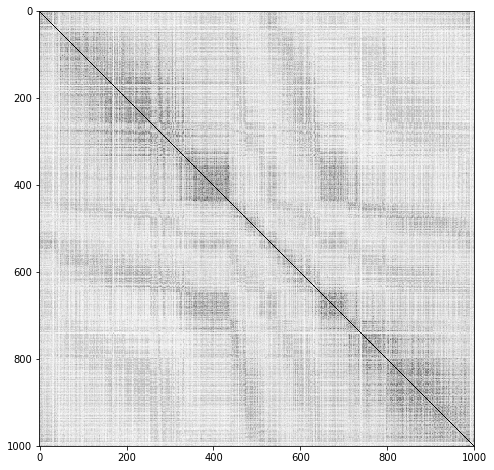

In [3]:
mat_dis = mat_dis1
N = mat_dis.shape[0]
mat_full = mat_dis + mat_dis.T - np.ones((N,N))
np.fill_diagonal(mat_full, 0)

idx_s = np.argsort(view_point)
gridix = np.ix_(idx_s,idx_s)
plt.imshow(mat_full[gridix])

for rr in np.random.randint(N,size=10):
    ref = rr
    print(view_point[ref])
    dis_rst = mat_full[rr]
    min_idx = np.argsort(dis_rst)
    for tt in range(1,6):
        match = min_idx[tt]
        print(view_point[match], end=' ')
        
    print('.')

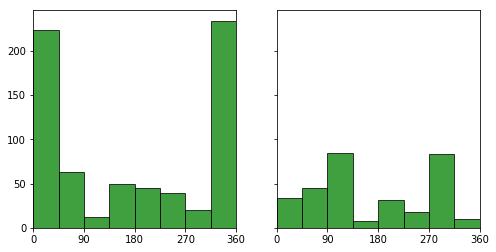

0.173811563624 0.0912227927926
0.221945731394 0.100763508428


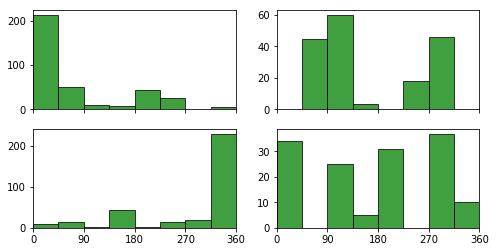

In [4]:
from sklearn.cluster import SpectralClustering
W_mat = 1. - mat_full
K = 2
cls_solver = SpectralClustering(n_clusters=K,affinity='precomputed', random_state=666)
lb = cls_solver.fit_predict(W_mat)

f, axes = plt.subplots(1,K, sharex=True, sharey=True, figsize=(8,4))
axes[0].set_xlim([0,360])
axes[0].set_xticks([0,90,180,270,360])

for k in range(K):
    axes[k].hist(np.array(view_point)[lb==k], bins=8, range=[0,360], facecolor='green', alpha=0.75,edgecolor='k')

plt.show()

idx2 = []
W_mat2 = []
lb2 = []
for k in range(K):
    idx2.append(np.where(lb==k)[0])
    W_mat2.append(W_mat[np.ix_(idx2[k],idx2[k])])
    print(np.mean(W_mat2[k]), np.std(W_mat2[k]))
    
    cls_solver = SpectralClustering(n_clusters=2,affinity='precomputed', random_state=999)
    lb2.append(cls_solver.fit_predict(W_mat2[k]))
    
K2=2
f, axes = plt.subplots(2,K, sharex=True, sharey=False, figsize=(8,4))
axes[0][0].set_xlim([0,360])
axes[0][0].set_xticks([0,90,180,270,360])
for k in range(K2*K):
    a = k//2
    b = k%2
    axes[b][a].hist(np.array(view_point)[idx2[a]][lb2[a]==b], bins=8, range=[0,360], facecolor='green', alpha=0.75, edgecolor='k')

plt.show()